# **Homework 3**

In questo homework ci occuperemo di di affrontare un problema di classificazione *utilizzando MLP su un dataset affetto da rumore nel training set* che può portare a overfit. 

L'obbiettivo è scegliere i migliori parametri del modello e applicare delle tecniche che riducono l'**overfitting**.

## **Import delle librerie**

In [1]:
#Import delle librerie per la risoluzione
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# nomi classi CIFAR-10
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

## **Funzione per la pulizia del dataset**
Applichiamo una funzione che ci permette di ridurre la saturazione dell'immagine, in modo da nascondere quanto più possibile il rumore presente nel dataset

In [3]:
import matplotlib.colors

def neutralize_colored_square(img, threshold=40):
    img = img.astype(np.float32)
    hsv = matplotlib.colors.rgb_to_hsv(img / 255.0)
    hue, sat, val = hsv[..., 0], hsv[..., 1], hsv[..., 2]
    mask = sat > (threshold / 100.0)
    sat[mask] *= 0.1  # riduzione drastica saturazione
    hsv[..., 1] = sat
    rgb = matplotlib.colors.hsv_to_rgb(hsv) * 255.0
    return np.clip(rgb, 0, 255).astype(np.uint8)

## **Caricamento del dataset e visualizzazione dei dati**
Il dataset che utilizzeremo è una variante del `CIFAR-10` affetta da *rumore*. Il dataset è composto da 60.000 immagini RGB a bassa risoluzione (32x32 pixel), suddivise in 10 categorie.

Ogni classe è bilanciata, con 6.000 esempi (5.000 per il training set e 1.000 per il test set). Il nostro compito sarà quello di utilizzare MLP cercando di evitare l'overfitting del modello.

In [4]:
#Caricamento dei dati
x_train = np.load('/kaggle/input/cifar10-hw3/cifar_hw3/x_train.npy')
y_train = np.load('/kaggle/input/cifar10-hw3/cifar_hw3/y_train.npy').ravel()
x_val   = np.load('/kaggle/input/cifar10-hw3/cifar_hw3/x_val.npy')
y_val   = np.load('/kaggle/input/cifar10-hw3/cifar_hw3/y_val.npy').ravel()
x_test  = np.load('/kaggle/input/cifar10-hw3/cifar_hw3/x_test.npy')
y_test  = np.load('/kaggle/input/cifar10-hw3/cifar_hw3/y_test.npy').ravel()

print("Dati caricati:")
print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"x_val  : {x_val.shape}, y_val  : {y_val.shape}")
print(f"x_test : {x_test.shape}, y_test : {y_test.shape}")

Dati caricati:
x_train: (40000, 32, 32, 3), y_train: (40000,)
x_val  : (10000, 32, 32, 3), y_val  : (10000,)
x_test : (10000, 32, 32, 3), y_test : (10000,)


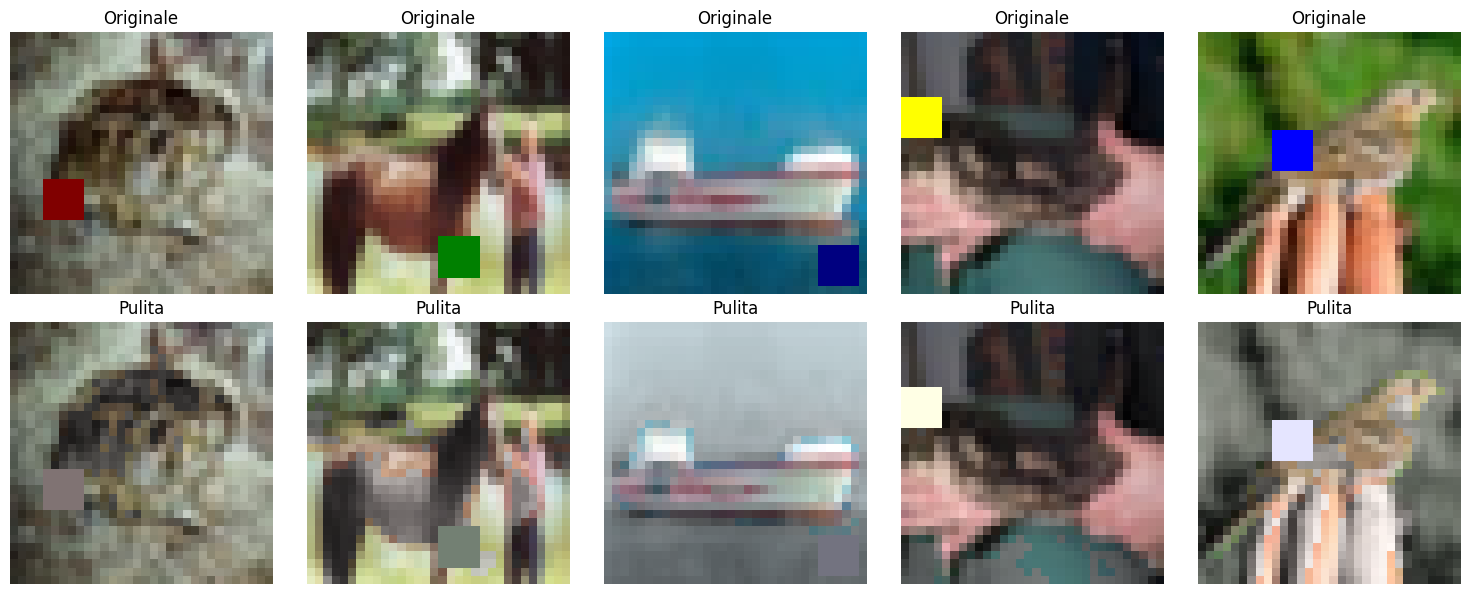

In [5]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    axes[0, i].imshow(x_train[i])
    axes[0, i].set_title("Originale")
    axes[0, i].axis("off")

    cleaned = neutralize_colored_square(x_train[i])
    axes[1, i].imshow(cleaned)
    axes[1, i].set_title("Pulita")
    axes[1, i].axis("off")
plt.tight_layout()
plt.show()

## **Pulizia delle immagini e preprocessamento dei dati**

In [6]:
# Pulizia immagini
x_train_clean = np.array([neutralize_colored_square(img) for img in x_train])
x_val_clean   = np.array([neutralize_colored_square(img) for img in x_val])

x_train_flat = x_train_clean.reshape(x_train.shape[0], -1)
x_val_flat   = x_val_clean.reshape(x_val.shape[0], -1)
x_test_flat  = x_test.reshape(x_test.shape[0], -1)


scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_flat)
x_val_scaled   = scaler.transform(x_val_flat)
x_test_scaled  = scaler.transform(x_test_flat)

# PCA per ridurre rumore e dimensionalità
pca = PCA(n_components=512, random_state=42)
x_train_pca = pca.fit_transform(x_train_scaled)
x_val_pca   = pca.transform(x_val_scaled)
x_test_pca  = pca.transform(x_test_scaled)

print(f"PCA completata: {pca.n_components_} componenti principali")

PCA completata: 512 componenti principali


## **Model Selection**

In [7]:
param_grid = {
    'hidden_layer_sizes': [(64,), (128,), (256,), (128, 64), (256, 128), (256, 128, 64)],
    'alpha': [0.01, 0.1, 1.0],
}

best_params = None
best_val_acc = 0.0

print("\nInizio model selection...\n")

for hidden in param_grid['hidden_layer_sizes']:
    for alpha in param_grid['alpha']:
        print(f"Test: hidden_layer_sizes={hidden}, alpha={alpha}")

        mlp_tmp = MLPClassifier(
            hidden_layer_sizes=hidden,
            activation='relu',
            alpha=alpha,
            batch_size=64,
            learning_rate_init=0.001,
            max_iter=20,
            solver='adam',
            random_state=42
        )
        mlp_tmp.fit(x_train_pca, y_train)
        val_pred_tmp = mlp_tmp.predict(x_val_pca)
        val_acc_tmp = accuracy_score(y_val, val_pred_tmp)
        print(f"Val Accuracy: {val_acc_tmp:.4f}")

        if val_acc_tmp > best_val_acc:
            best_val_acc = val_acc_tmp
            best_params = {'hidden_layer_sizes': hidden, 'alpha': alpha}
            print("Nuovo best!")

print("\nModel selection completata.")
print(f"Migliori parametri trovati: {best_params}, Val Accuracy={best_val_acc:.4f}")


Inizio model selection...

Test: hidden_layer_sizes=(64,), alpha=0.01


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Val Accuracy: 0.4330
Nuovo best!
Test: hidden_layer_sizes=(64,), alpha=0.1


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Val Accuracy: 0.4519
Nuovo best!
Test: hidden_layer_sizes=(64,), alpha=1.0


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Val Accuracy: 0.4770
Nuovo best!
Test: hidden_layer_sizes=(128,), alpha=0.01


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Val Accuracy: 0.4296
Test: hidden_layer_sizes=(128,), alpha=0.1


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Val Accuracy: 0.4486
Test: hidden_layer_sizes=(128,), alpha=1.0


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Val Accuracy: 0.4850
Nuovo best!
Test: hidden_layer_sizes=(256,), alpha=0.01


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Val Accuracy: 0.4404
Test: hidden_layer_sizes=(256,), alpha=0.1


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Val Accuracy: 0.4535
Test: hidden_layer_sizes=(256,), alpha=1.0


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Val Accuracy: 0.4795
Test: hidden_layer_sizes=(128, 64), alpha=0.01


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Val Accuracy: 0.4168
Test: hidden_layer_sizes=(128, 64), alpha=0.1


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Val Accuracy: 0.4433
Test: hidden_layer_sizes=(128, 64), alpha=1.0


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Val Accuracy: 0.4636
Test: hidden_layer_sizes=(256, 128), alpha=0.01


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Val Accuracy: 0.4356
Test: hidden_layer_sizes=(256, 128), alpha=0.1


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Val Accuracy: 0.4603
Test: hidden_layer_sizes=(256, 128), alpha=1.0


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Val Accuracy: 0.4800
Test: hidden_layer_sizes=(256, 128, 64), alpha=0.01


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Val Accuracy: 0.4427
Test: hidden_layer_sizes=(256, 128, 64), alpha=0.1


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Val Accuracy: 0.4602
Test: hidden_layer_sizes=(256, 128, 64), alpha=1.0
Val Accuracy: 0.4703

Model selection completata.
Migliori parametri trovati: {'hidden_layer_sizes': (128,), 'alpha': 1.0}, Val Accuracy=0.4850


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


## **Early Stopping**

In [8]:
#INIZIALIZZAZIONE FINALE MODELLO con i parametri scelti
mlp = MLPClassifier(
    hidden_layer_sizes=best_params['hidden_layer_sizes'],
    activation='relu',
    alpha=best_params['alpha'],
    batch_size=64,
    learning_rate_init=0.001,
    max_iter=1,
    solver='adam',
    warm_start=True,
    random_state=42,
    verbose=False
)

#EARLY STOPPING
n_epochs = 100
patience = 10
tolerance = 1e-4
best_val_acc = 0.0
epochs_without_improvement = 0

train_acc_list = []
val_acc_list = []

print("\nInizio training con early stopping...\n")

for epoch in range(n_epochs):
    mlp.fit(x_train_pca, y_train)

    train_pred = mlp.predict(x_train_pca)
    val_pred   = mlp.predict(x_val_pca)

    train_acc = accuracy_score(y_train, train_pred)
    val_acc   = accuracy_score(y_val, val_pred)

    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

    print(f"Epoca {epoch+1}/{n_epochs}")
    print(f"Accuracy Train: {train_acc:.4f}")
    print(f"Accuracy Val:   {val_acc:.4f}")

    if val_acc > best_val_acc + tolerance:
        best_val_acc = val_acc
        epochs_without_improvement = 0
        print("Miglioramento trovato!")
        print("----------------------")
    else:
        epochs_without_improvement += 1
        print(f"Nessun miglioramento: {epochs_without_improvement}/{patience}")
        print("----------------------")

    if epochs_without_improvement >= patience:
        print("Early stopping attivato!")
        break


Inizio training con early stopping...



/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoca 1/100
Accuracy Train: 0.4869
Accuracy Val:   0.4190
Miglioramento trovato!
----------------------
Epoca 2/100
Accuracy Train: 0.5252
Accuracy Val:   0.4446
Miglioramento trovato!
----------------------
Epoca 3/100
Accuracy Train: 0.5375
Accuracy Val:   0.4562
Miglioramento trovato!
----------------------
Epoca 4/100
Accuracy Train: 0.5426
Accuracy Val:   0.4615
Miglioramento trovato!
----------------------
Epoca 5/100
Accuracy Train: 0.5493
Accuracy Val:   0.4640
Miglioramento trovato!
----------------------
Epoca 6/100
Accuracy Train: 0.5545
Accuracy Val:   0.4679
Miglioramento trovato!
----------------------
Epoca 7/100
Accuracy Train: 0.5587
Accuracy Val:   0.4715
Miglioramento trovato!
----------------------
Epoca 8/100
Accuracy Train: 0.5614
Accuracy Val:   0.4725
Miglioramento trovato!
----------------------
Epoca 9/100
Accuracy Train: 0.5629
Accuracy Val:   0.4732
Miglioramento trovato!
----------------------
Epoca 10/100
Accuracy Train: 0.5662
Accuracy Val:   0.4721
Nessu

## **Valutazione finale**


Accuracy finale:
Train Accuracy: 0.5786
Val Accuracy  : 0.4715
Test Accuracy : 0.4511

Classification Report (Test):
              precision    recall  f1-score   support

    airplane       0.61      0.50      0.55      1000
  automobile       0.62      0.46      0.53      1000
        bird       0.39      0.31      0.35      1000
         cat       0.31      0.20      0.25      1000
        deer       0.33      0.35      0.34      1000
         dog       0.49      0.26      0.34      1000
        frog       0.34      0.75      0.47      1000
       horse       0.49      0.58      0.53      1000
        ship       0.54      0.67      0.60      1000
       truck       0.55      0.42      0.48      1000

    accuracy                           0.45     10000
   macro avg       0.47      0.45      0.44     10000
weighted avg       0.47      0.45      0.44     10000



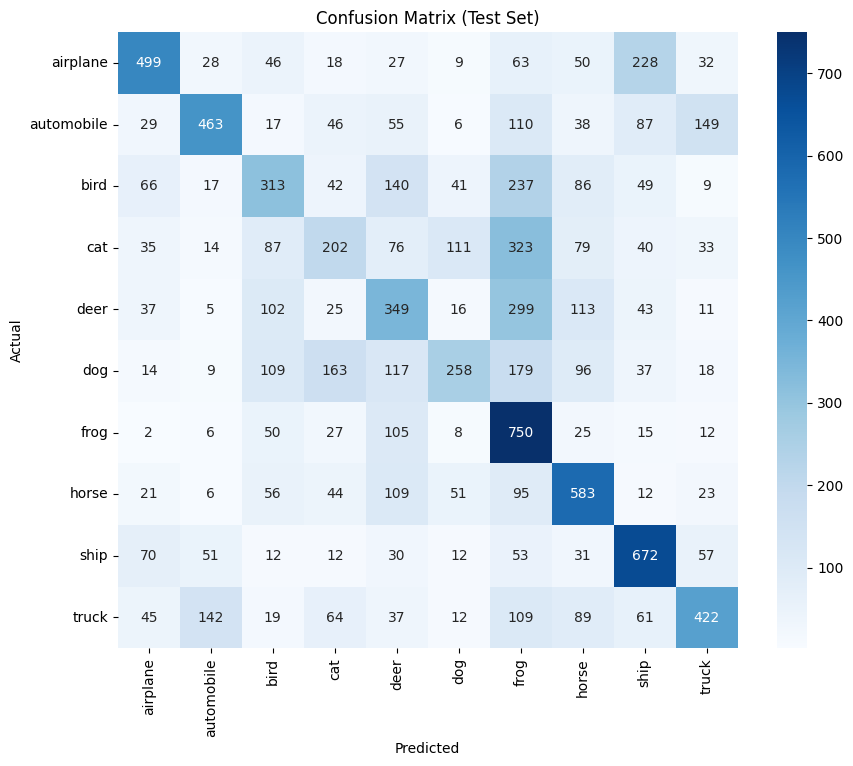

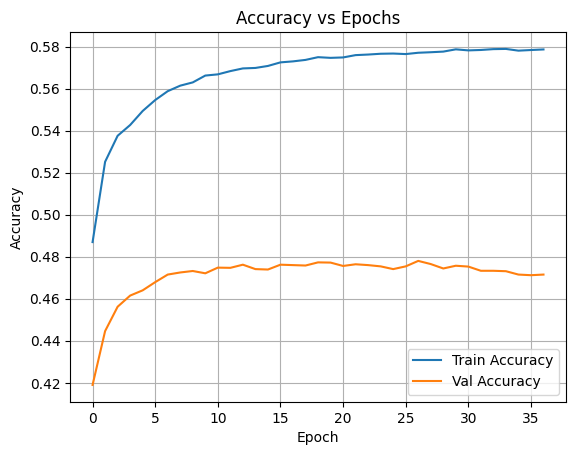

In [9]:
#Valutazione finale
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
test_pred = mlp.predict(x_test_pca)
print("\nAccuracy finale:")
print(f"Train Accuracy: {train_acc_list[-1]:.4f}")
print(f"Val Accuracy  : {val_acc_list[-1]:.4f}")
print(f"Test Accuracy : {accuracy_score(y_test, test_pred):.4f}")
print("\nClassification Report (Test):")
print(classification_report(y_test, test_pred, target_names=class_names))

#Confusion matrix
conf_matrix = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#Curva di accuratezza
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()